In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import re
import requests
pd.options.display.max_rows = 5000 

In [2]:
import requests

url = "https://yahoo-finance15.p.rapidapi.com/api/yahoo/hi/history/cobr.l/1d"

headers = {
    'x-rapidapi-key': "9cd97ba3camsh244cbd2e3e420a4p1e83c0jsne0fdd0787f8e",
    'x-rapidapi-host': "yahoo-finance15.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers)

print(response.text)

{
    "meta": {
        "currency": "GBp",
        "symbol": "COBR.L",
        "exchangeName": "LSE",
        "instrumentType": "EQUITY",
        "firstTradeDate": 1542268800,
        "regularMarketTime": 1628177339,
        "gmtoffset": 3600,
        "timezone": "BST",
        "exchangeTimezoneName": "Europe/London",
        "regularMarketPrice": 1.85,
        "chartPreviousClose": 1.75,
        "priceHint": 4,
        "dataGranularity": "1d",
        "range": ""
    },
    "items": {
        "1542268800": {
            "date": "15-11-2018",
            "open": 1.67,
            "high": 1.75,
            "low": 1.67,
            "close": 1.75,
            "adjclose": 1.75
        },
        "1542355200": {
            "date": "16-11-2018",
            "open": 1.75,
            "high": 1.75,
            "low": 1.75,
            "close": 1.75,
            "adjclose": 1.75
        },
        "1542614400": {
            "date": "19-11-2018",
            "open": 1.65,
            "high": 1

In [3]:
string = response.text

In [4]:
string[:1000]

'{\n    "meta": {\n        "currency": "GBp",\n        "symbol": "COBR.L",\n        "exchangeName": "LSE",\n        "instrumentType": "EQUITY",\n        "firstTradeDate": 1542268800,\n        "regularMarketTime": 1628177339,\n        "gmtoffset": 3600,\n        "timezone": "BST",\n        "exchangeTimezoneName": "Europe/London",\n        "regularMarketPrice": 1.85,\n        "chartPreviousClose": 1.75,\n        "priceHint": 4,\n        "dataGranularity": "1d",\n        "range": ""\n    },\n    "items": {\n        "1542268800": {\n            "date": "15-11-2018",\n            "open": 1.67,\n            "high": 1.75,\n            "low": 1.67,\n            "close": 1.75,\n            "adjclose": 1.75\n        },\n        "1542355200": {\n            "date": "16-11-2018",\n            "open": 1.75,\n            "high": 1.75,\n            "low": 1.75,\n            "close": 1.75,\n            "adjclose": 1.75\n        },\n        "1542614400": {\n            "date": "19-11-2018",\n          

- 获取日期data

In [5]:
def get_dates(string):
    date = re.compile('"date":((.*),)')
    date = date.findall(string)
    date = [i[0][2:12] for i in date]
    date = [datetime.strptime(i, "%d-%m-%Y").strftime("%Y-%m-%d") for i in date]
    return date

In [6]:
date = get_dates(string)
print( date[:5] )

['2018-11-15', '2018-11-16', '2018-11-19', '2018-11-20', '2018-11-21']


- 获取close价格

In [7]:
def get_close(string):
    close = re.compile('"close":((.*),)')
    close = close.findall(string)
    close = [float(i[1].strip()) for i in close]
    return close

In [8]:
close = get_close(string)
close[:5]

[1.75, 1.75, 1.65, 1.65, 1.65]

- form dataframe

In [9]:
def form_df(date, close, col_name1, col_name2):
    return pd.DataFrame({col_name1:date, col_name2:close })

In [10]:
cobr = form_df(date, close, 'date', 'cobr_close')
cobr.set_index('date', drop=True, inplace=True)
cobr.tail(3)

,cobr_close
date,
2021-08-03,1.85
2021-08-04,1.85
2021-08-05,1.85


- save dataframe as csv

- IPO and Placing info

In [11]:
p1_sprice = 2.25
p1_wprice = 3
p1_date = '2020-01-01'
p1_swratio = 1/1
p2_sprice = 2.3
p2_wprice = 3
p2_date = '2020-09-01'
p2_swratio = 1/1

#### 技巧：没有数值的Entry设置成None的话，它们就不参与之后的计算。省很多事儿。

In [12]:
cobr['p1_sprice'] = [p1_sprice if i  >= p1_date else None for i in cobr.index]
cobr['p1_wprice'] = [p1_wprice if i  >= p1_date else None for i in cobr.index]

cobr['p2_sprice'] = [p2_sprice if i  >= p2_date else None for i in cobr.index]
cobr['p2_wprice'] = [p2_wprice if i  >= p2_date else None for i in cobr.index]

- If each Placing or IPO investor invest 10000 pounds ever time, what are the positions look like？

In [13]:
fund = 10000
split = 2

In [14]:
cobr['p1_sposition'] = [round(fund/split/p1_sprice,2) if i >= p1_date else 0 for i in cobr.index]
cobr['p1_wposition'] = cobr['p1_sposition']*p1_swratio


cobr['p2_sposition'] = [round(fund/split/p2_sprice,2) if i >= p2_date else 0 for i in cobr.index]
cobr['p2_wposition'] = cobr['p2_sposition']*p2_swratio

- What is the profit looks like， respectively?

In [15]:
# Profit from the shares, 

cobr['p1_sprft'] = cobr.cobr_close - cobr['p1_sprice']


cobr['p2_sprft'] = cobr.cobr_close - cobr['p2_sprice']


In [16]:
# Profit from the warranties

p1_wprofit = []
for i,j in zip(cobr.cobr_close, cobr['p1_wprice']):
    if i - j >0:
        p1_wprofit.append(round(i-j,2))
    else:
        p1_wprofit.append(0)

cobr['p1_wprft'] = p1_wprofit

p2_wprofit = []
for i,j in zip(cobr.cobr_close, cobr['p2_wprice']):
    if i - j >0:
        p2_wprofit.append(round(i-j,2))
    else:
        p2_wprofit.append(0)

cobr['p2_wprft'] = p2_wprofit

In [17]:
cobr = cobr.fillna(0)

In [18]:
cobr

,cobr_close,p1_sprice,p1_wprice,p2_sprice,p2_wprice,p1_sposition,p1_wposition,p2_sposition,p2_wposition,p1_sprft,p2_sprft,p1_wprft,p2_wprft
date,,,,,,,,,,,,,
2018-11-15,1.75,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-11-16,1.75,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-11-19,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-11-20,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-11-21,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-11-22,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-11-23,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-11-26,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-11-27,1.25,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


- Total Profit per share

In [19]:
cobr['prft_per_share'] = cobr['p1_sprft']+cobr['p2_sprft']+cobr['p1_wprft']+cobr['p2_wprft']

cobr['p1_10k_rtn'] = cobr['p1_sposition']*cobr['p1_sprft']+cobr['p1_wposition']*cobr['p1_wprft']

cobr['p2_10k_rtn'] = cobr['p2_sposition']*cobr['p2_sprft']+cobr['p2_wposition']*cobr['p2_wprft']

cobr['total_rtn'] = cobr['p1_10k_rtn'] + cobr['p2_10k_rtn']

In [20]:
cobr

,cobr_close,p1_sprice,p1_wprice,p2_sprice,p2_wprice,p1_sposition,p1_wposition,p2_sposition,p2_wposition,p1_sprft,p2_sprft,p1_wprft,p2_wprft,prft_per_share,p1_10k_rtn,p2_10k_rtn,total_rtn
date,,,,,,,,,,,,,,,,,
2018-11-15,1.75,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000
2018-11-16,1.75,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000
2018-11-19,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000
2018-11-20,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000
2018-11-21,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000
2018-11-22,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000
2018-11-23,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000
2018-11-26,1.65,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000
2018-11-27,1.25,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000


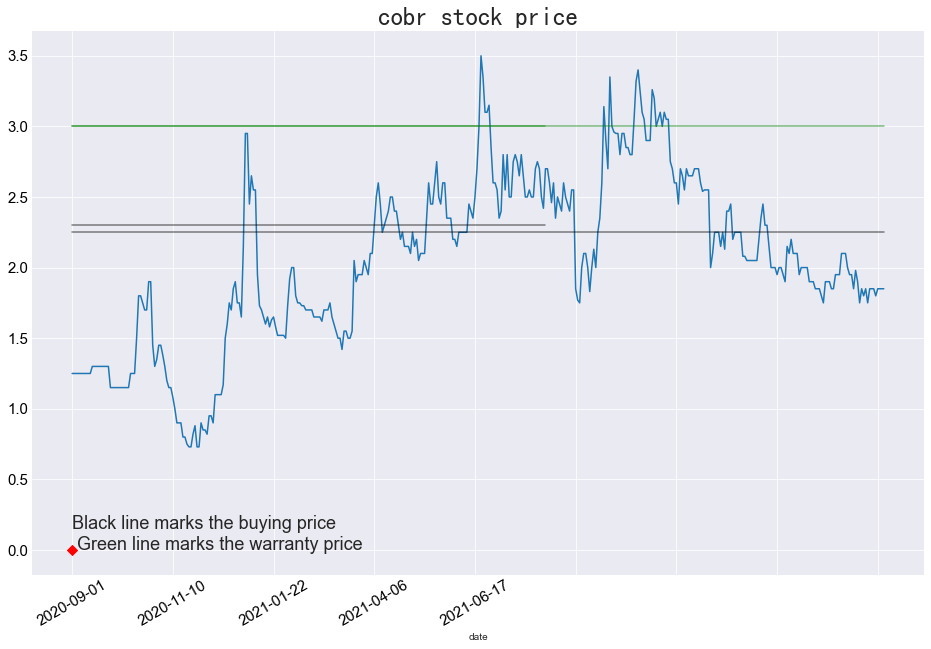

In [32]:
title = 'cobr stock price'
plt.figure(figsize=(16,10))
plt.style.use('seaborn-darkgrid')
cobr.cobr_close[cobr.index>=p1_date].plot()
cobr.p1_sprice[cobr.index>=p1_date].plot(color='k', alpha=0.5)
cobr.p2_sprice[cobr.index>=p2_date].plot(color='k', alpha=0.5)
cobr.p1_wprice[cobr.index>=p1_date].plot(color='g', alpha=0.5)
cobr.p2_wprice[cobr.index>=p2_date].plot(color='g', alpha=0.5)
plt.scatter(p1_date, 0, color='r', marker='D', s=50)
plt.text(p1_date, 0, 'Black line marks the buying price \n Green line marks the warranty price', fontsize=18)
plt.yticks(fontsize=15,color='k')
plt.xticks( fontsize=15,color='k', rotation=30)
plt.title('{}'.format(title), fontproperties = 'SimHei',fontsize=25)
# plt.legend(('p1_profit','p2_profit'),loc="upper left", fontsize=20 );
plt.savefig('{}'.format(title),dpi=300,bbox_inches ='tight',pad_inches = 1,transparent = True,orientation ='landscape')
plt.show()

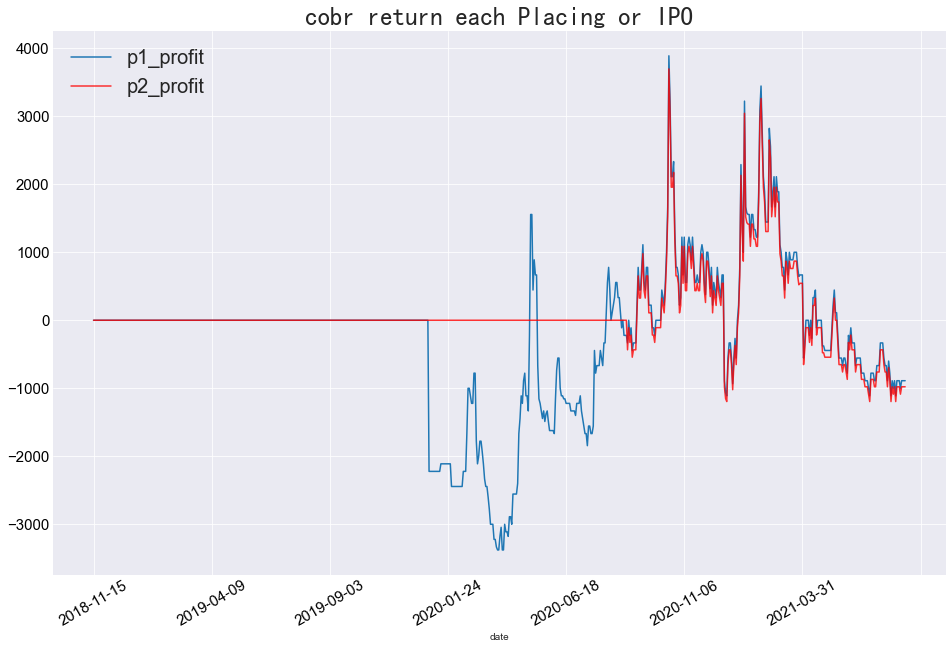

In [31]:
title = 'cobr return each Placing or IPO'
plt.figure(figsize=(16,10))
plt.style.use('seaborn-darkgrid')
cobr.p1_10k_rtn.plot()
cobr.p2_10k_rtn.plot(color='r', alpha=0.8)
plt.yticks(fontsize=15,color='k')
plt.xticks( fontsize=15,color='k', rotation=30)
plt.title('{}'.format(title), fontproperties = 'SimHei',fontsize=25)
plt.legend(('p1_profit','p2_profit'),loc="upper left", fontsize=20 );
plt.savefig('{}'.format(title),dpi=300,bbox_inches ='tight',pad_inches = 1,transparent = True,orientation ='landscape')
plt.show()

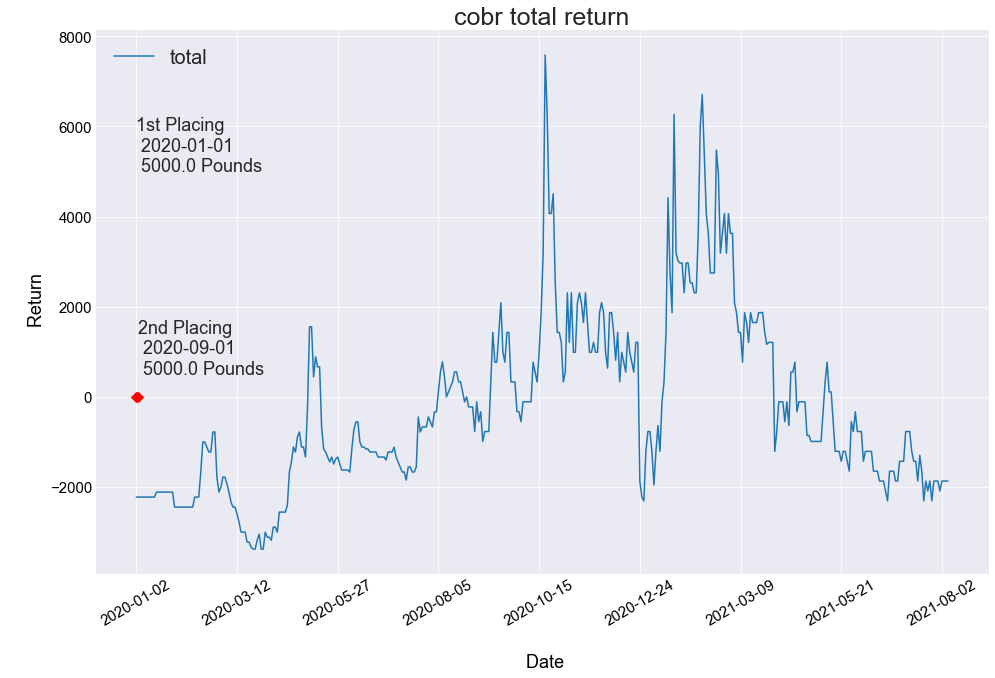

In [24]:
title = 'cobr total return'
plt.figure(figsize=(16,10))
plt.style.use('seaborn-darkgrid')
# cobr.loc[cobr.index >= p1_date].p1_10k_rtn.plot()
# cobr.loc[cobr.index >= p1_date].p2_10k_rtn.plot(color='r', alpha=0.8)
cobr.loc[cobr.index >= p1_date].total_rtn.plot()
plt.text(p1_date, 0+5000, '1st Placing \n {} \n {} Pounds'.format(p1_date, fund/split), fontsize=18)
plt.text(p2_date, 0+500, '2nd Placing \n {} \n {} Pounds'.format(p2_date, fund/split), fontsize=18)
plt.scatter(p1_date, 0, color='r', marker='D', s=50)
plt.scatter(p2_date, 0, color='r', marker='D', s=50)
plt.yticks(fontsize=15,color='k')
plt.xticks( fontsize=15,color='k', rotation=30)
plt.title('{}'.format(title), fontsize=25)
plt.legend(['total'],loc="upper left", fontsize=20 )
plt.ylabel('\n Return', fontsize=18, color='k')
plt.xlabel('\n Date', fontsize=18,color='k')
plt.savefig('{}'.format(title),dpi=300,bbox_inches ='tight',pad_inches = 1,transparent = True,orientation ='landscape')

plt.show()

In [184]:
pwd

'/Users/paxton615/Github_Personal/Notes/Notes/Financial_models/SI Stocks'

In [ ]:
cobr.to_csv(r'/Users/paxton615/Desktop/cobr.csv')